In [2]:
import logging, os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('fivethirtyeight')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [3]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('../output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# Change UTC Time to CST Time 
from datetime import datetime

CST_time_list = []
for time in df['Time'].to_list():
    CST_time_list.append(datetime.fromtimestamp(time))

df['Time'] = pd.DataFrame(CST_time_list)

# Date Time: Minutes Seconds
date_time = df['Time'].dt.strftime('%M %S')

# checking our dataframe once again
df.head()

  

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,2022-01-08 08:35:42,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,2022-01-08 08:35:43,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,2022-01-08 08:35:44,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,2022-01-08 08:35:45,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,2022-01-08 08:35:46,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


In [4]:
df.loc[0, 'Time']

Timestamp('2022-01-08 08:35:42')

In [5]:
date_time

0       35 42
1       35 43
2       35 44
3       35 45
4       35 46
        ...  
3797    01 55
3798    01 55
3799    01 55
3800    01 55
3801    01 55
Name: Time, Length: 3802, dtype: object

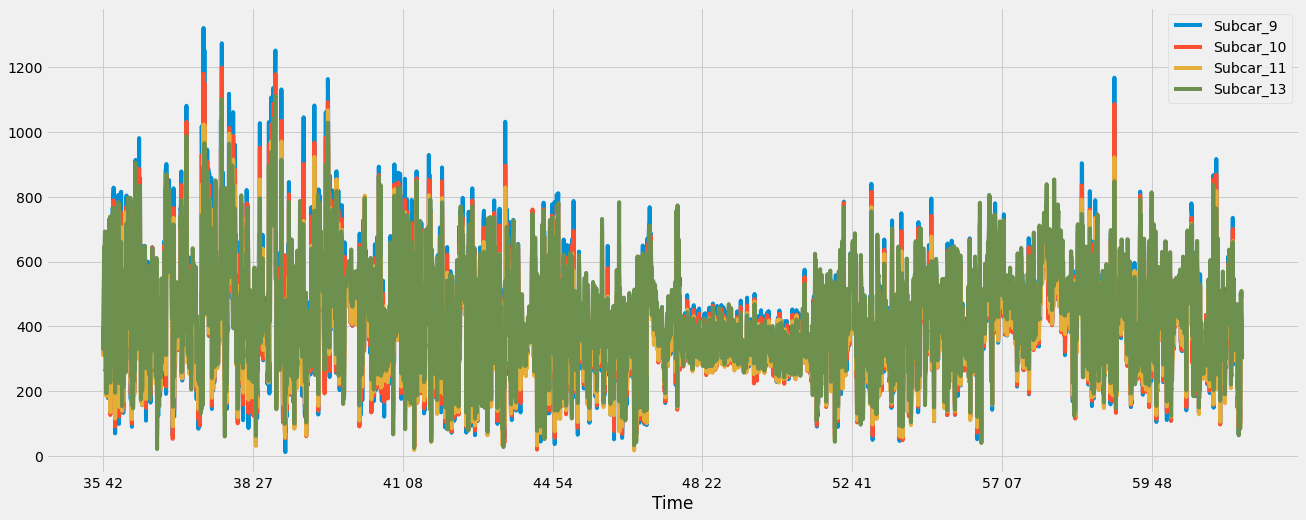

In [6]:
plot_cols = ['Subcar_9','Subcar_10', 'Subcar_11', 'Subcar_13']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)

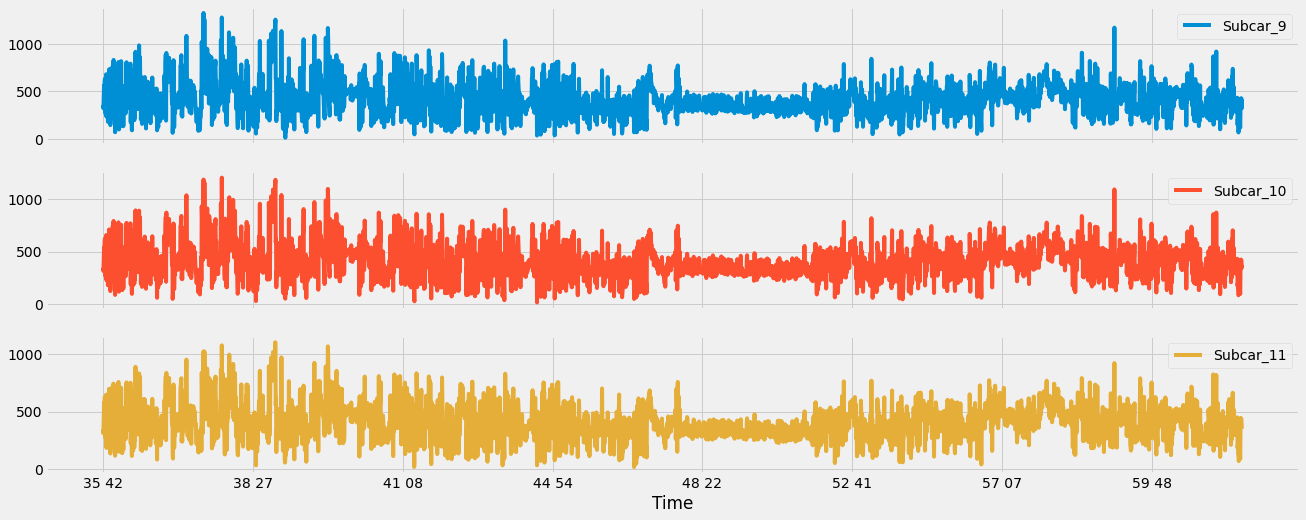

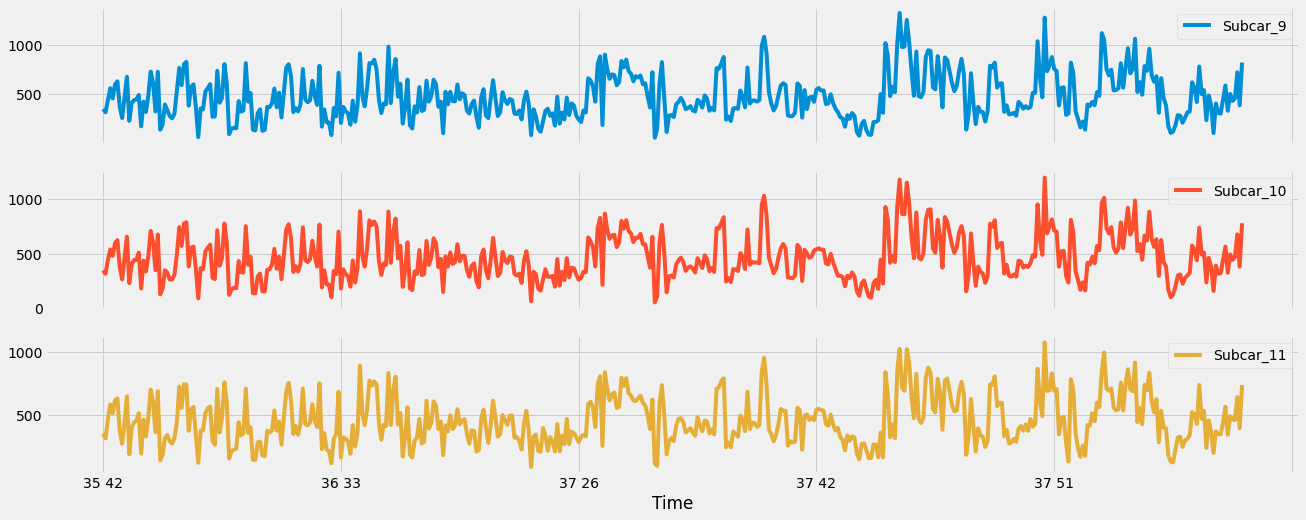

In [7]:
plot_cols = ['Subcar_9', 'Subcar_10', 'Subcar_11']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [8]:
df = df.drop([df.columns[0]], axis=1) 
df = df.round(0).astype(int)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

val_mean = train_df.mean()
val_std = train_df.std()

test_mean = train_df.mean()
test_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - val_mean) / val_std
test_df = (test_df - test_mean) / test_std


In [10]:
class WindowGenerator():
        def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):

        # Store the raw data.
                self.train_df = train_df
                self.val_df = val_df
                self.test_df = test_df

        # Work out the label column indices.
                self.label_columns = label_columns
                if label_columns is not None:
                    self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
                self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

        # Work out the window parameters.
                self.input_width = input_width
                self.label_width = label_width
                self.shift = shift

                self.total_window_size = input_width + shift

                self.input_slice = slice(0, input_width)
                self.input_indices = np.arange(self.total_window_size)[self.input_slice]

                self.label_start = self.total_window_size - self.label_width
                self.labels_slice = slice(self.label_start, None)
                self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        def __repr__(self):
                return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])

In [11]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['Subcar_9'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['Subcar_9']

In [12]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Subcar_9'] )
print(w2.__repr__())

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Subcar_9']


In [13]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [14]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 58)
Inputs shape: (3, 6, 58)
Labels shape: (3, 1, 1)


In [15]:
def plot(self, model=None, plot_col='Subcar_9', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(20, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]', fontsize=14, fontweight='bold',
                   horizontalalignment='center')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10, )
        plt.xticks(fontsize=14)

        plt.yticks(fontsize=14)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64,)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64, )

        if n == 0:
            plt.legend(fontsize=13)

    plt.xlabel('Time [h]', fontsize=14, fontweight='bold',
               horizontalalignment='center')

WindowGenerator.plot = plot

In [16]:
# Create tf.data.Datasets
#@tf.autograph.experimental.do_not_convert
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [17]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [18]:
# Single step models
# The simplest model you can build on this sort of data is one that predicts a single feature's value—1 time step

single_step_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, # 100
    label_columns=['Subcar_9'])
single_step_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Subcar_9']

In [19]:
# Baseline 
# start with a model that just returns the current carrier as the prediction,
#  predicting "No change". This is a reasonable baseline since carrier changes slowly

class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
    
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [20]:
# Instantiate and evealuate the model
baseline = Baseline(label_index=column_indices['Subcar_9'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Subcar_9']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 [==============================] - 0s 5ms/step - loss: 0.6740 - mean_absolute_error: 0.5659


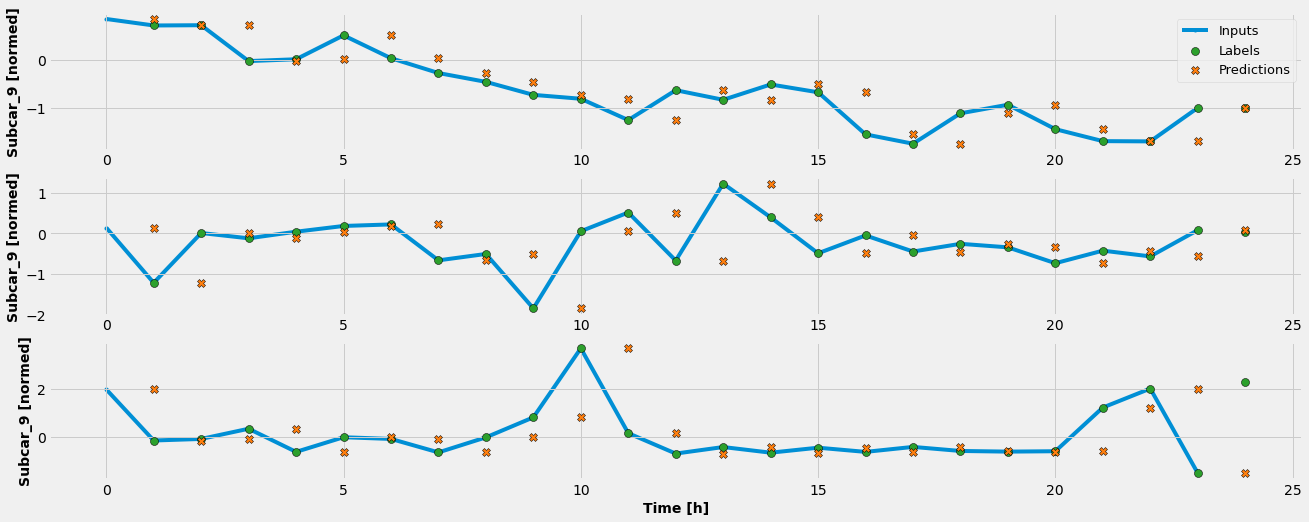

In [28]:
single_step_window.plot(baseline)
#plt.savefig('../images/predict_1.eps', dpi=120)


In [23]:
wide_window = WindowGenerator(
    input_width=100, label_width=100, shift=1,
    label_columns=['Subcar_9'])

wide_window
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 100, 58)
Output shape: (32, 100, 1)


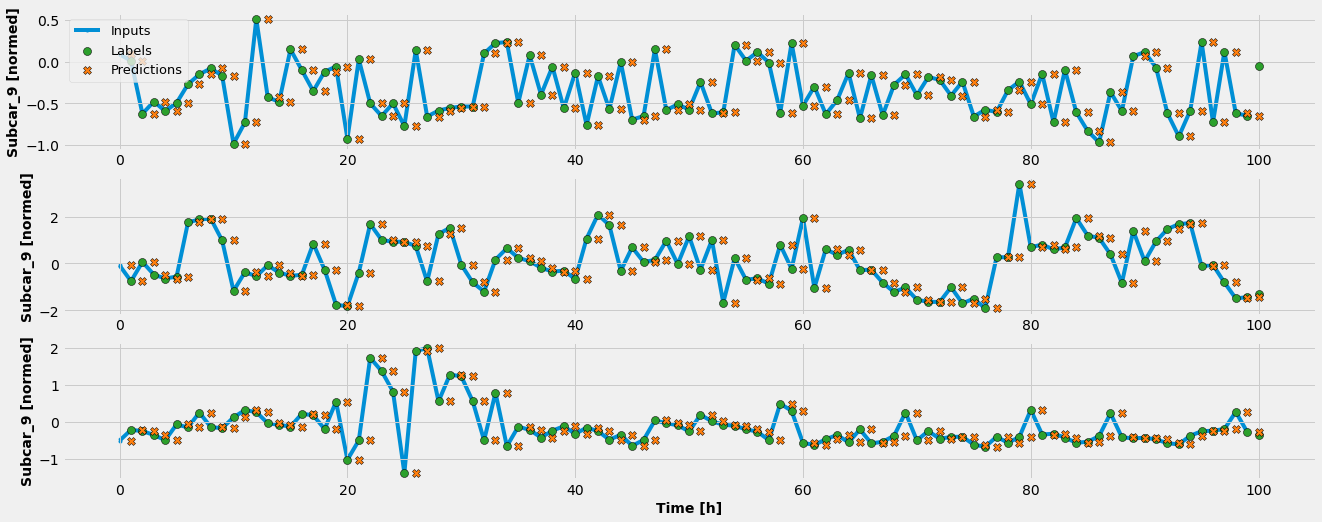

In [25]:
wide_window.plot(baseline)
# plt.savefig('../images/predict_2.png', dpi=120)


In [26]:
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


21/21 [==============================] - 0s 9ms/step - loss: 0.6513 - mean_absolute_error: 0.5574
